In [1]:
%cd /content
!git clone https://github.com/Tmqng/ATR-Code

/content
Cloning into 'ATR-Code'...
remote: Enumerating objects: 437, done.
remote: Counting objects: 100% (437/437), done.
remote: Compressing objects: 100% (254/254), done.
remote: Total 437 (delta 184), reused 363 (delta 119), pack-reused 0 (from 0)
Receiving objects: 100% (437/437), 6.95 MiB | 19.13 MiB/s, done.
Resolving deltas: 100% (184/184), done.


In [2]:
import os

import json
import subprocess
import zipfile

# Step 1: Set up Kaggle credentials
kaggle_username = "minhqunnguyen"
kaggle_api_key = "KGAT_874d32201f32459c120dc5947083a3d8"

os.makedirs(os.path.expanduser('~/.kaggle'), exist_ok=True)

kaggle_json = {
    "username": kaggle_username,
    "key": kaggle_api_key
}

json_path = os.path.expanduser('~/.kaggle/kaggle.json')
with open(json_path, 'w') as f:
    json.dump(kaggle_json, f)

os.chmod(json_path, 0o600)

# Step 2: Verify authentication works
result = subprocess.run(['kaggle', 'api', '-v'], capture_output=True, text=True)
print("Kaggle API version:", result.stdout)

# Step 3: Try downloading your private dataset
dataset_identifier = "minhqunnguyen/mstar-images-et-json"
output_dir = "/content/ATR-Code/datasets/MSTAR/"
os.makedirs(output_dir, exist_ok=True)

print(f"Attempting to download: {dataset_identifier}")
!cd {output_dir} && kaggle datasets download -d {dataset_identifier}

# Find the zip file
zip_file = os.path.join(output_dir, "mstar-images-et-json.zip")

if os.path.exists(zip_file):
    print(f"Extracting {zip_file}...")
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(output_dir)
    print("✓ Done!")
else:
    print(f"Zip file not found at {zip_file}")
    print(f"Files in {output_dir}:")
    for f in os.listdir(output_dir):
        print(f"  - {f}")

print("✓ Download complete!")

Kaggle API version: 
Attempting to download: minhqunnguyen/mstar-images-et-json
Dataset URL: https://www.kaggle.com/datasets/minhqunnguyen/mstar-images-et-json
License(s): unknown
 86% 235M/273M [00:00<00:00, 465MB/s]
100% 273M/273M [00:00<00:00, 425MB/s]
Extracting /content/ATR-Code/datasets/MSTAR/mstar-images-et-json.zip...
✓ Done!
✓ Download complete!


In [3]:
%cd /content/ATR-Code
!git pull

/content/ATR-Code
Already up to date.


In [ ]:
from absl import logging
from absl import flags
from absl import app

from tqdm import tqdm

from torch.utils import tensorboard
from torch.utils.data import DataLoader, random_split

import torchvision
import torch

import numpy as np

import json

import sys
import os


import matplotlib.pyplot as plt
import numpy as np

# Get the project root
project_root = os.getcwd()

# Add src/ to path
sys.path.append(os.path.join(project_root, "src"))

# modules in src
from data.MSTAR.paper_AConvNet import preprocess
from data.MSTAR.paper_AConvNet import loader
from utils import common
from models import AConvNet
from models._base import Model

DATA_PATH = 'datasets/MSTAR/MSTAR_IMG_JSON'

# DATA_PATH = 'datasets/MSTAR/mstar_data_paper_AConvNet/'

model_str = 'AConvNet'


# flags.DEFINE_string('experiments_path', os.path.join(common.project_root, 'experiments'), help='')
# flags.DEFINE_string('config_name', f'{model_str}/config/AConvNet-SOC.json', help='')
# FLAGS = flags.FLAGS


common.set_random_seed(12321)

In [5]:
# experiments_path = FLAGS.experiments_path
# config_name = FLAGS.config_name

# config = common.load_config(os.path.join(experiments_path, config_name))

experiments_path = os.path.join(common.project_root, 'experiments')

config = {
  "model_name": "AConvNet-SOC",
  "dataset": "SOC",
  "num_classes": 10,
  "channels": 1,
  "batch_size": 100,
  "epochs": 5,
  "momentum": 0.9,
  "lr": 1e-3,
  "lr_step": [50],
  "lr_decay": 0.1,
  "weight_decay": 4e-3,
  "dropout_rate": 0.5
}

dataset = config['dataset']
classes = config['num_classes']
channels = config['channels']
epochs = config['epochs']
batch_size = config['batch_size']

lr = config['lr']
lr_step = config['lr_step']
lr_decay = config['lr_decay']

weight_decay = config['weight_decay']
dropout_rate = config['dropout_rate']

model_name = config['model_name']

# run(epochs, dataset, classes, channels, batch_size,
#     lr, lr_step, lr_decay, weight_decay, dropout_rate,
#     model_name, experiments_path)

In [6]:
def load_dataset(path, is_train, name, batch_size, augment):
    """
    Docstring for load_dataset

    :param path: Description
    :param is_train: Description
    :param name: Description
    :param batch_size: Description

    Load train, val or test dataset and apply transformations.
    """

    if augment:
        val_transform = torchvision.transforms.Compose([preprocess.CenterCrop(94)])
        train_transform = torchvision.transforms.Compose([preprocess.RandomCrop(94)])

    else:
        val_transform = torchvision.transforms.Compose([preprocess.CenterCrop(94)])
        train_transform = torchvision.transforms.Compose([preprocess.RandomCrop(94)])

    _dataset = loader.Dataset(
        path, name=name, is_train=is_train,
        transform=None
    )

    for images, labels, _ in _dataset:
        print(f"\nFirst batch shapes:")
        print(type(images))
        print(f"  Images: {images.shape}, dtype: {images.dtype}")
        break

    if is_train:

        if augment:
            # Data_augmentation (in preprocess file)
            print(f"Augmenting training data with patches...")
            # Extract patches from training data
            augmented_samples = preprocess.augment_dataset_with_patches(
                _dataset,
                # patch_size=patch_size,
                # stride=stride,
                # chip_size=chip_size,
                desc="Train augmentation"
            )

            print(f"\nRésultats augmentation :")
            print(f"  Train : {len(_dataset)} images → {len(augmented_samples)} patches")
            print(f"  Facteur : ~{len(augmented_samples) / len(_dataset):.0f}x (13x13 = 169 patches/image)")

            augmented_dataset = preprocess.AugmentedDataset(augmented_samples)
        else:
            augmented_dataset = _dataset

        # Split into train (80%) and validation (20%)
        train_size = int(0.8 * len(augmented_dataset))
        val_size = len(augmented_dataset) - train_size

        train_dataset, val_dataset = random_split(augmented_dataset, [train_size, val_size])

        for images, _, _ in train_dataset:
            print(images.shape)
            break

        # CenterCrop for val and RandomCrop for train
        train_dataset_transformed = preprocess.TransformWrapper(train_dataset, train_transform)
        val_dataset_transformed = preprocess.TransformWrapper(val_dataset, val_transform)


        for images, _, _ in train_dataset_transformed:
            print(images.shape)
            break

        train_data_loader = torch.utils.data.DataLoader(
            train_dataset_transformed, batch_size=batch_size, shuffle=is_train, num_workers=1
        )

        val_data_loader = torch.utils.data.DataLoader(
            val_dataset_transformed, batch_size=batch_size, shuffle=False, num_workers=1
        )

        # Check first batch
        for images, labels, _ in train_data_loader:
            print(f"\nFirst batch shapes:")
            print(f"  Images: {images.shape}, dtype: {images.dtype}")
            print(f"  Labels: {labels.shape}, dtype: {labels.dtype}")
            print(f"  Labels values: {labels.tolist()[:10]}")
            print(f"  Unique labels: {torch.unique(labels).tolist()}")
            break

        return train_data_loader, val_data_loader


    else:
        test_dataset_transformed = preprocess.TransformWrapper(_dataset, val_transform)
        data_loader = torch.utils.data.DataLoader(
            test_dataset_transformed, batch_size=batch_size, shuffle=is_train, num_workers=1
        )
        return data_loader


@torch.no_grad()
def validation(m, ds):
    num_data = 0
    corrects = 0

    # Test loop
    m.net.eval()
    _softmax = torch.nn.Softmax(dim=1)
    for i, data in enumerate(tqdm(ds)):
        if i == 0:
            print(f"Data structure: {type(data)}")
            print(f"Data length: {len(data)}")
            images, labels, _ = data
            print(f"Images shape: {images.shape}")
            print(f"Labels shape: {labels.shape}")
            print(f"Unique labels in batch: {torch.unique(labels)}")
        images, labels, _ = data

        images = images.to(m.device)
        labels = labels.to(m.device)

        predictions = m.inference(images)
        predictions = predictions.to(m.device)
        predictions = _softmax(predictions)

        _, predictions = torch.max(predictions.data, 1)

        # DEBUG: Check predictions
        if i == 0:
            print(f"Predicted classes: {predictions[:10]}")
            print(f"True labels: {labels[:10]}")
            print(f"Matches: {(predictions == labels)[:10]}")

        labels = labels.type(torch.LongTensor)
        num_data += labels.size(0)
        corrects += (predictions == labels.to(m.device)).sum().item()

    accuracy = 100 * corrects / num_data
    return accuracy

In [10]:
# Décomposition de la fonction run

# Load data
train_set, val_set = load_dataset(DATA_PATH, True, dataset, batch_size, False)
test_set = load_dataset(DATA_PATH, False, dataset, batch_size, False)

load train data set: 100%|██████████| 2747/2747 [00:01<00:00, 1763.33it/s]



First batch shapes:
<class 'torch.Tensor'>
  Images: torch.Size([1, 128, 128]), dtype: torch.float32
Augmenting training data with patches...


Train augmentation: 100%|██████████| 2747/2747 [00:13<00:00, 201.66it/s]


Résultats augmentation :
  Train : 2747 images → 134603 patches
  Facteur : ~49x (13x13 = 169 patches/image)
torch.Size([1, 94, 94])
torch.Size([1, 94, 94])



First batch shapes:
  Images: torch.Size([100, 1, 94, 94]), dtype: torch.float32
  Labels: torch.Size([100]), dtype: torch.int64
  Labels values: [2, 3, 2, 1, 7, 3, 6, 3, 1, 8]
  Unique labels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


load test data set: 100%|██████████| 2425/2425 [00:01<00:00, 2083.24it/s]


First batch shapes:
<class 'torch.Tensor'>
  Images: torch.Size([1, 128, 128]), dtype: torch.float32



--- Displaying images from Train Set ---


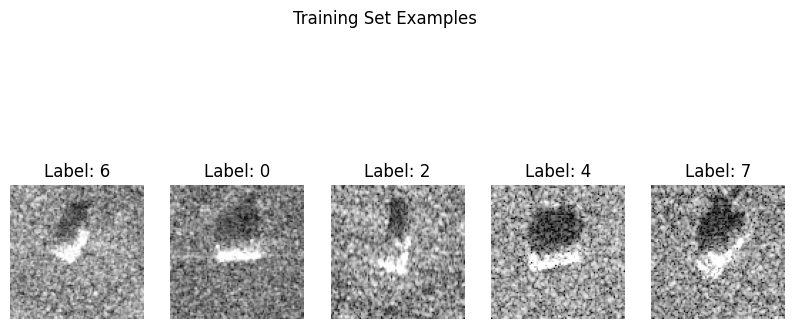


--- Displaying images from Validation Set ---


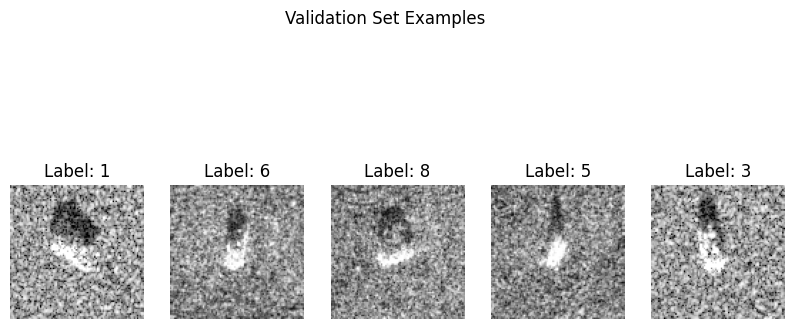

In [12]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img, title=None):
    # Convert tensor to numpy array
    npimg = img.numpy()
    # For single channel images, remove the channel dimension
    if npimg.shape[0] == 1:
        plt.imshow(np.transpose(npimg, (1, 2, 0)).squeeze(), cmap='gray')
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title is not None:
        plt.title(title)
    plt.axis('off')

# Get a batch of training images
print("\n--- Displaying images from Train Set ---")
for images, labels, _ in train_set:
    fig_train = plt.figure(figsize=(10, 5))
    for i in range(min(5, len(images))): # Display first 5 images
        ax = fig_train.add_subplot(1, 5, i + 1)
        imshow(images[i], title=f'Label: {labels[i].item()}')
    plt.suptitle("Training Set Examples")
    plt.show()
    break # Only display one batch

# Get a batch of validation images
print("\n--- Displaying images from Validation Set ---")
for images, labels, _ in val_set:
    fig_val = plt.figure(figsize=(10, 5))
    for i in range(min(5, len(images))): # Display first 5 images
        ax = fig_val.add_subplot(1, 5, i + 1)
        imshow(images[i], title=f'Label: {labels[i].item()}')
    plt.suptitle("Validation Set Examples")
    plt.show()
    break # Only display one batch

In [ ]:
m = Model(
    classes=classes, dropout_rate=dropout_rate, channels=channels,
    lr=lr, lr_step=lr_step, lr_decay=lr_decay,
    weight_decay=weight_decay
)

model_path = os.path.join(experiments_path, f'{model_str}/models/{model_name}')
if not os.path.exists(model_path):
    os.makedirs(model_path, exist_ok=True)

history_path = os.path.join(experiments_path, f'{model_str}/history')
if not os.path.exists(history_path):
    os.makedirs(history_path, exist_ok=True)

history = {
    'train_loss': [],
    'train_accuracy': [],
    'val_loss': [],
    'val_accuracy': []
}

for epoch in range(epochs):
    _loss = []

    m.net.train()
    for i, data in enumerate(tqdm(train_set)):
        images, labels, _ = data
        _loss.append(m.optimize(images, labels))

    if m.lr_scheduler:
        lr = m.lr_scheduler.get_last_lr()[0]
        m.lr_scheduler.step()

    train_accuracy = validation(m, train_set)
    val_accuracy = validation(m, val_set)

    print(
        f'Epoch: {epoch + 1:03d}/{epochs:03d} | loss={np.mean(_loss):.4f} | lr={lr} | Train accuracy={train_accuracy:.2f} | Validation accuracy={val_accuracy:.2f}'
    )

    history['train_loss'].append(np.mean(_loss))
    history['train_accuracy'].append(train_accuracy)
    history['val_accuracy'].append(val_accuracy)

    if experiments_path:
        m.save(os.path.join(model_path, f'model-{epoch + 1:03d}.pth'))

    with open(os.path.join(history_path, f'history-{model_name}.json'), mode='w', encoding='utf-8') as f:
        json.dump(history, f, ensure_ascii=True, indent=2)

Device used: cpu


  0%|          | 0/22 [00:00<?, ?it/s]

Data structure: <class 'list'>
Data length: 3
Images shape: torch.Size([100, 1, 94, 94])
Labels shape: torch.Size([100])
Unique labels in batch: tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


  5%|▍         | 1/22 [00:00<00:15,  1.33it/s]

Predicted classes: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
True labels: tensor([8, 0, 8, 9, 2, 5, 5, 5, 0, 3])
Matches: tensor([False, False, False, False, False, False, False, False, False, False])


  0%|          | 0/6 [00:00<?, ?it/s]

Data structure: <class 'list'>
Data length: 3
Images shape: torch.Size([100, 1, 94, 94])
Labels shape: torch.Size([100])
Unique labels in batch: tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


 17%|█▋        | 1/6 [00:00<00:02,  2.17it/s]

Predicted classes: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
True labels: tensor([0, 7, 4, 6, 2, 9, 2, 1, 0, 5])
Matches: tensor([False, False, False, False, False, False, False,  True, False, False])


100%|██████████| 6/6 [00:01<00:00,  3.20it/s]


Epoch: 001/005 | loss=69676.6250 | lr=0.001 | Train accuracy=8.65 | Validation accuracy=7.82


  0%|          | 0/22 [00:00<?, ?it/s]

Data structure: <class 'list'>
Data length: 3
Images shape: torch.Size([100, 1, 94, 94])
Labels shape: torch.Size([100])
Unique labels in batch: tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


  5%|▍         | 1/22 [00:00<00:09,  2.17it/s]

Predicted classes: tensor([8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
True labels: tensor([8, 7, 6, 0, 6, 5, 2, 7, 0, 1])
Matches: tensor([ True, False, False, False, False, False, False, False, False, False])


  0%|          | 0/6 [00:00<?, ?it/s]

Data structure: <class 'list'>
Data length: 3
Images shape: torch.Size([100, 1, 94, 94])
Labels shape: torch.Size([100])
Unique labels in batch: tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


 17%|█▋        | 1/6 [00:00<00:03,  1.37it/s]

Predicted classes: tensor([8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
True labels: tensor([0, 7, 4, 6, 2, 9, 2, 1, 0, 5])
Matches: tensor([False, False, False, False, False, False, False, False, False, False])


100%|██████████| 6/6 [00:03<00:00,  1.91it/s]


Epoch: 002/005 | loss=2.6734 | lr=0.001 | Train accuracy=11.15 | Validation accuracy=9.82


  0%|          | 0/22 [00:00<?, ?it/s]

Data structure: <class 'list'>
Data length: 3
Images shape: torch.Size([100, 1, 94, 94])
Labels shape: torch.Size([100])
Unique labels in batch: tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


  5%|▍         | 1/22 [00:00<00:20,  1.04it/s]

Predicted classes: tensor([8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
True labels: tensor([5, 2, 0, 3, 3, 4, 9, 0, 2, 0])
Matches: tensor([False, False, False, False, False, False, False, False, False, False])


  0%|          | 0/6 [00:00<?, ?it/s]

Data structure: <class 'list'>
Data length: 3
Images shape: torch.Size([100, 1, 94, 94])
Labels shape: torch.Size([100])
Unique labels in batch: tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


 17%|█▋        | 1/6 [00:00<00:02,  2.14it/s]

Predicted classes: tensor([8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
True labels: tensor([0, 7, 4, 6, 2, 9, 2, 1, 0, 5])
Matches: tensor([False, False, False, False, False, False, False, False, False, False])


100%|██████████| 6/6 [00:01<00:00,  3.32it/s]


Epoch: 003/005 | loss=2.3033 | lr=0.001 | Train accuracy=11.15 | Validation accuracy=9.82


 23%|██▎       | 5/22 [00:05<00:18,  1.08s/it]


KeyboardInterrupt: 